In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
sess = tf.Session()

iris = datasets.load_iris()

num_pts = len(iris.data)
num_feats = len(iris.data[0])

In [3]:
#We will now set the groups, generations, and create the variables we need for the graph

# There are 3 types of iris flowers, see if we can predict them
k=3 
generations = 25

data_points = tf.Variable(iris.data)
cluster_labels = tf.Variable(tf.zeros([num_pts], dtype=tf.int64))

In [4]:
#The next variables we need are the centroids for each group. We will initalize the centroids
#for the k-means algorithm by randomly choosing three different points in the iris dataset
rand_starts = np.array([iris.data[np.random.choice(len(iris.data))] for _ in range(k)])

centroids = tf.Variable(rand_starts)

In [5]:
#Now we need to calculate the distances between each of the data points and each of the 
#centroids. We do this by expanding the centroids into a matrix and the same for the data 
#points. We will then calculate the Euclidean distances between the two matrices
centroid_matrix = tf.reshape(tf.tile(centroids, [num_pts, 1]), [num_pts, k, num_feats])
# Then we reshape the data points into k (3) repeats
point_matrix = tf.reshape(tf.tile(data_points, [1, k]), [num_pts, k, num_feats])
distances = tf.reduce_sum(tf.square(point_matrix - centroid_matrix), axis=2)

In [6]:
#The centroid assigment is then the closest centroid to each data point
centroid_group = tf.argmin(distances, 1)

In [8]:
#Now we have to calculate the group averate to get the new centroid 
def data_group_avg(group_ids, data):
    # Sum each group
    sum_total = tf.unsorted_segment_sum(data, group_ids, 3)
    # Count each group
    num_total = tf.unsorted_segment_sum(tf.ones_like(data), group_ids, 3)
    # Calculate average
    avg_by_group = sum_total/num_total
    return(avg_by_group)

means = data_group_avg(centroid_group, data_points)

update = tf.group(centroids.assign(means), cluster_labels.assign(centroid_group))

In [9]:
init = tf.global_variables_initializer()

sess.run(init)

In [10]:
#We will iterate through the generations and update the centroids for each group accordingly
for i in range(generations):
    print('Calculating gen {}, out of {}.'.format(i, generations))
    _, centroid_group_count = sess.run([update, centroid_group])
    group_count = []
    for ix in range(k):
        group_count.append(np.sum(centroid_group_count==ix))
    print('Group counts: {}'.format(group_count))

Calculating gen 0, out of 25.
Group counts: [54, 91, 5]
Calculating gen 1, out of 25.
Group counts: [53, 84, 13]
Calculating gen 2, out of 25.
Group counts: [51, 77, 22]
Calculating gen 3, out of 25.
Group counts: [50, 68, 32]
Calculating gen 4, out of 25.
Group counts: [50, 65, 35]
Calculating gen 5, out of 25.
Group counts: [50, 62, 38]
Calculating gen 6, out of 25.
Group counts: [50, 62, 38]
Calculating gen 7, out of 25.
Group counts: [50, 62, 38]
Calculating gen 8, out of 25.
Group counts: [50, 62, 38]
Calculating gen 9, out of 25.
Group counts: [50, 62, 38]
Calculating gen 10, out of 25.
Group counts: [50, 62, 38]
Calculating gen 11, out of 25.
Group counts: [50, 62, 38]
Calculating gen 12, out of 25.
Group counts: [50, 62, 38]
Calculating gen 13, out of 25.
Group counts: [50, 62, 38]
Calculating gen 14, out of 25.
Group counts: [50, 62, 38]
Calculating gen 15, out of 25.
Group counts: [50, 62, 38]
Calculating gen 16, out of 25.
Group counts: [50, 62, 38]
Calculating gen 17, out o

In [11]:
#To verify our clustering, we can use the clusters to make predictions. We now see how many
#data points are in a similar cluster of same iris species.
[centers, assignments] = sess.run([centroids, cluster_labels])

# Find which group assignments correspond to which group labels
# First, need a most common element function
def most_common(my_list):
    return(max(set(my_list), key=my_list.count))

label0 = most_common(list(assignments[0:50]))
label1 = most_common(list(assignments[50:100]))
label2 = most_common(list(assignments[100:150]))

group0_count = np.sum(assignments[0:50]==label0)
group1_count = np.sum(assignments[50:100]==label1)
group2_count = np.sum(assignments[100:150]==label2)

accuracy = (group0_count + group1_count + group2_count)/150.

print('Accuracy: {:.2}'.format(accuracy))

Accuracy: 0.89


In [12]:
#To visually see our groupings and if they have indeed seperated out the iris species, we 
#will transform the four dimensions to two dimensions using PCA, and plot the data points
#and groups. After the PCA decomposition, we create predictions on a grid of x-y values for
#plotting a color graph
pca_model = PCA(n_components=2)
reduced_data = pca_model.fit_transform(iris.data)
# Transform centers
reduced_centers = pca_model.transform(centers)

# Step size of mesh for plotting
h = .02

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Get k-means classifications for the grid points
xx_pt = list(xx.ravel())
yy_pt = list(yy.ravel())
xy_pts = np.array([[x,y] for x,y in zip(xx_pt, yy_pt)])
mytree = cKDTree(reduced_centers)
dist, indexes = mytree.query(xy_pts)

# Put the result into a color plot
indexes = indexes.reshape(xx.shape)

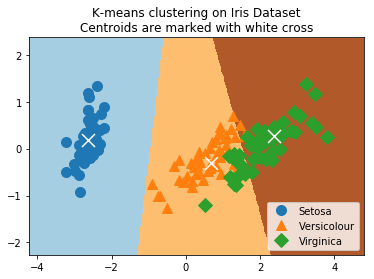

In [13]:
#And here is matplotlib code to combine our findings on one graph. 
plt.figure(1)
plt.clf()
plt.imshow(indexes, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# Plot each of the true iris data groups
symbols = ['o', '^', 'D']
label_name = ['Setosa', 'Versicolour', 'Virginica']
for i in range(3):
    temp_group = reduced_data[(i*50):(50)*(i+1)]
    plt.plot(temp_group[:, 0], temp_group[:, 1], symbols[i], markersize=10, label=label_name[i])
# Plot the centroids as a white X
plt.scatter(reduced_centers[:, 0], reduced_centers[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on Iris Dataset\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='lower right')
plt.show()